In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
#SIFT

#load images
imgl = cv2.imread('2Hill.JPG')
imgr = cv2.imread('1Hill.JPG')

imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()

keypoints_l, descriptors_l = sift_obj.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = sift_obj.detectAndCompute(imgr, None)

#time to compare speed of SIFT and SURF later on
keypoints_lf = sift_obj.detect(imgl, None)


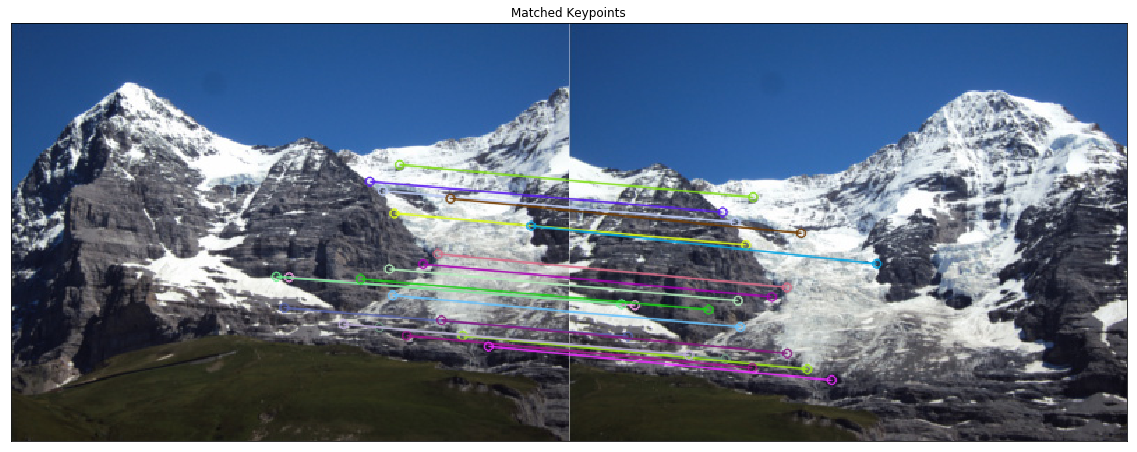

In [2]:
#PART 2 matching keypoints

# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
t1 = time.time()
matches = bf.match(descriptors_r,descriptors_l)
t_sift = (time.time()-t1)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(imgr,keypoints_r,imgl,keypoints_l, matches[:20], imgr, flags=2)

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imgmatch)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()
#part2 done



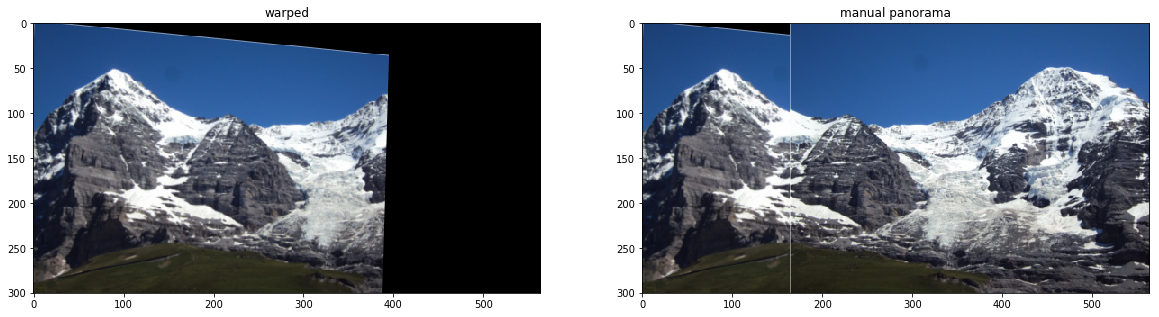

In [3]:
#PART3 HOMOGRAPHY

# Arrange matching keypoints in two separate lists

def warpPerspectivePadded(
        src, dst_shape, M):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    src : image to be warped.
    dst : shape of static image i.e. dst.shape 
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0]])
    # transform points
    transf_lin_pts = M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)

    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    if min_x < 0:
        anchor_x = -min_x
    shifted_transf = M + [[0, 0, anchor_x], [0, 0, 0], [0, 0, 0]]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + dst_w + max(max_x, dst_w) - dst_w
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped


GoodMatches = []

for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_r[i].pt for (__, i) in GoodMatches])
mpl = np.float32([keypoints_l[i].pt for (i, __) in GoodMatches])

# find homography and wrap image accordingly
H, hTrans = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)

imgl_trans = warpPerspectivePadded(imgr, imgr.shape, H)
wimg = imgl_trans.copy()
#imgl_trans = cv2.warpPerspective(imgr, H, (imgr.shape[1],imgr.shape[0]))
#imgl_trans = cv2.warpPerspective(imgl, hTrans.dot(H))
imgl_trans[:,164:,:] = imgl

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(wimg)
plt.title("warped")
plt.subplot(122)
plt.imshow(imgl_trans)
plt.title("manual panorama")

plt.show()
#part 3 done

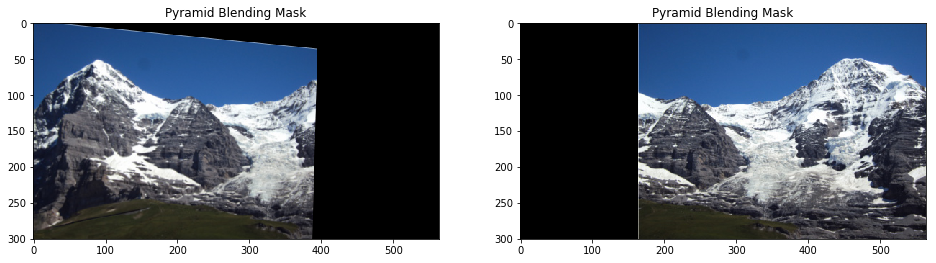

(300, 564, 3) (300, 564, 3)


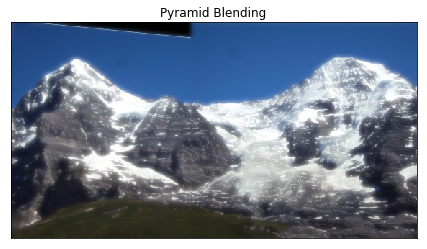

In [4]:
#PART4 pyramid stiching
#np.seterr(over='ignore')

A = cv2.copyMakeBorder(wimg, 0, 0, 0, 0, cv2.BORDER_CONSTANT)
B = imgl
B = cv2.copyMakeBorder(imgl, 0, 0, 0, A.shape[1] - B.shape[1], cv2.BORDER_CONSTANT)

height, width = B.shape[0:2]
tx, ty = 164, 0
M = np.float32([[1, 0, tx], [0, 1, ty]])
# also need to set the new size of the image
B = cv2.warpAffine(B, M, (width, height))

plt.figure(figsize=(16,16))
plt.subplot(121), plt.imshow(A)
plt.title('Pyramid Blending Mask')#, plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(B)
plt.title('Pyramid Blending Mask')#, plt.xticks([]), plt.yticks([])
plt.show()


print(A.shape, B.shape)
#A = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)
#B = cv2.cvtColor(B, cv2.COLOR_BGR2RGB)
# parameters
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

""" PYRAMID BLENDING """
row, col, dpt = A.shape
# generate Gaussian pyramid for imgA
G = A.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Gaussian pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((A.shape[0], A.shape[1]))
#start to 164 are 0, 164 to end are 1
mask[:, 250:] = 1
# blur mask
mask1 = cv2.GaussianBlur(mask, (g_size, g_size), 0)
# generate Gaussian pyramid
G = mask.copy()
GR = [G]

for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)
    
# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i
    
    # Now blend
    #plt.imshow(np.uint8((1-GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1)) * la)); plt.show()
    #plt.imshow(np.uint8(GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1)*lb)); plt.show()
    lp = (1-GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1)) * la + \
         GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1
    #print(i)
    #plt.imshow(lp); plt.show()

    
# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

#cv2.cvtColor(B, cv2.COLOR_BGR2RGB)
#cv2.cvtColor(B, cv2.COLOR_BGR2RGB)
# display results
plt.figure(figsize=(16,16))
plt.subplot(121), plt.imshow(rs_mask)
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
#PART 2.1 SURF
##CHANGE imgl_trans to photo generated by pyramid and we are good to goo

#pretend wimg is correct for now

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

img3 = cv2.imread('3Hill.JPG')
#convert images to gray
#imgl_trans_gray = cv2.cvtColor(imgl_trans, cv2.COLOR_RGB2GRAY)
#img3_gray = cv2.cvtColor(wimg, cv2.COLOR_BGR2GRAY)

#convert to RGB to display
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

#find keypoints and descriptors
keypoints_w, desW = surf.detectAndCompute(rs_mask, None)
keypoints_3, des3 = surf.detectAndCompute(img3, None)

##just for time measurment
keypoints_s = surf.detect(imgl, None)

#part 2.1 done


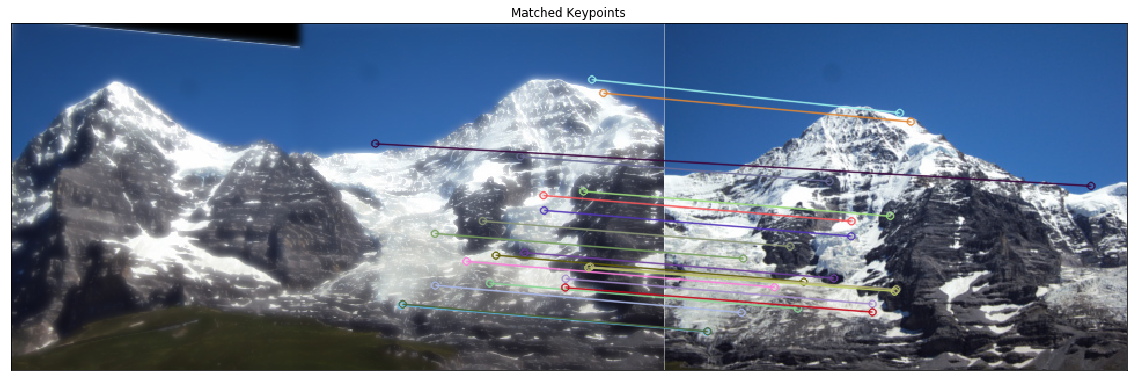

In [6]:
# PART 2.2 matching keypoints
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
t2 = time.time()
matches_surf = bf.match(desW,des3)
t_surf = (time.time()-t2)

# Sort them in the order of their distance.
matches_surf = sorted(matches_surf, key = lambda x:x.distance)
##r=w l=3
# Draw keypoints 
imgmatch_surf = cv2.drawMatches(rs_mask,keypoints_w,img3,keypoints_3, matches_surf[:20], img3, flags=2)

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imgmatch_surf)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()
#part2 done

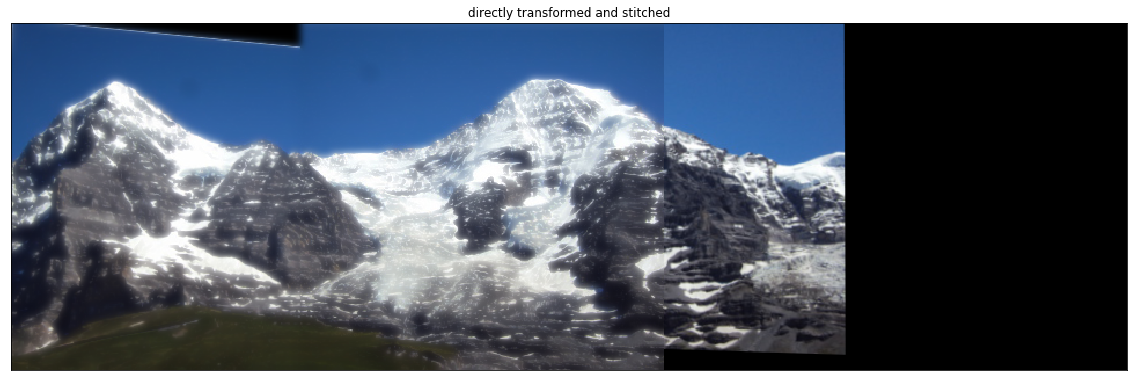

In [7]:
#part 3 find RANSAC and transform img3

GoodMatches = []

for i, m in enumerate(matches_surf):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpw = np.float32([keypoints_w[i].pt for (__, i) in GoodMatches])
mp3 = np.float32([keypoints_3[i].pt for (i, __) in GoodMatches])

# find homography and wrap image accordingly
H, hTrans = cv2.findHomography(mpw, mp3, cv2.RANSAC, 4)

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp3, mpw, cv2.RANSAC, 4)
wimg_surf = cv2.warpPerspective(img3, H, (img3.shape[1]+imgl_trans.shape[1],img3.shape[0]))
wimg_surf2 = wimg_surf.copy()
wimg_surf[:,:rs_mask.shape[1],:] = rs_mask

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(wimg_surf)
plt.title("directly transformed and stitched"), plt.xticks([]), plt.yticks([])
plt.show()
#part3 done

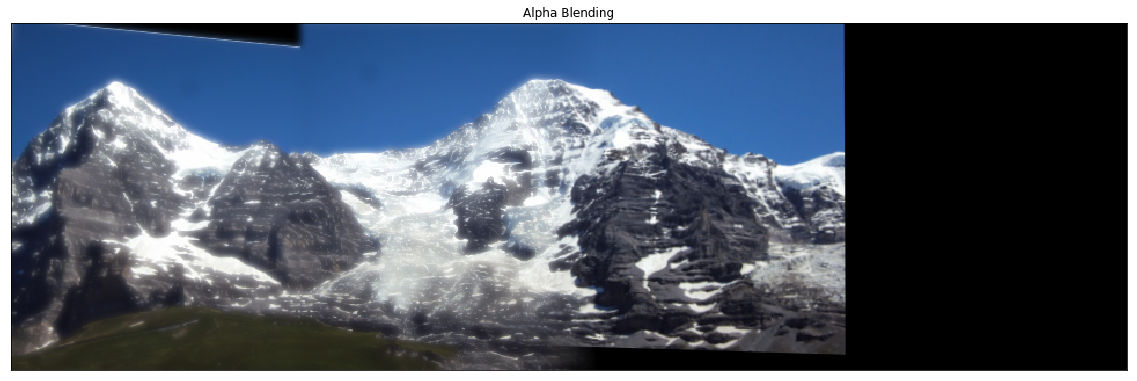

In [8]:
#part 4 linear blending
#two images are already merged in wimg_surf at imgl_trans.shape[1] = 564

A = cv2.copyMakeBorder(rs_mask, 0, 0, 0, wimg_surf2.shape[1] - rs_mask.shape[1], cv2.BORDER_CONSTANT)
B = wimg_surf2 #transformed but not stiched

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, round(A.shape[1]/2), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * A + alpha.reshape(1,-1,1)*B
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

# Reasoning Questions: 

### 1- Question 2.2.1: 
The main difference is that SURF is faster than SIFT. However, there are other difference such as:
- keypoint detection: SIFT uses different scale images convoluted with Gaussian function, while SURF uses the original image convoluted with different scale box filter. SIFT also finds more keypoints.
- Dimension: SIFT is 128 and SURF is 64
- Description: SIFT takes the maximum gradient in a box, while SURF uses a Haar wavelet response to calculate each sector in a circular area.
- Density: Given the larger number of keypoints in SIFT, it is expected to have heigher density.
- source: https://ijarcce.com/wp-content/uploads/2016/04/nCORETech-7.pdf

The next cell shows statistics of the performance of the two detectors: 

In [9]:
print("Average number of keypoints for SIFT= ", (len(keypoints_l)+len(keypoints_r))/2)
print("Average number of keypoints for SURF= ", (len(keypoints_w)+len(keypoints_3))/2)
print("\n\nTime for SIFT= ", t_sift)
print("Time for SURF= ", t_surf)

Average number of keypoints for SIFT=  1363.0
Average number of keypoints for SURF=  958.0


Time for SIFT=  0.07552576065063477
Time for SURF=  0.030523300170898438


### 2- Question 2.2.2:

Pyramid Pros:
- efficient as it doesn't use all pixels every time (hence the sape of the pyramid)
- balance between smoothing low frequency exposure variations and retaining sharp transition (SLIDES)

Pyramid Cons:
- as seen in the coding section, brightness in the image might get changed
- more steps (blurr, convolution, Laplacian... etc)

Linear Pros: 
- uses less processing power
- faster

Linear Cons:
- chance of gohsting if parameters are not chosen correctly
- performs worse than Pyramid Blending at low frequencies

### 3- Question 2.2.3

choosing randomly means that we are not always choosing the best matches. Over a very large set, choosing randomly might average out the result. However, for smaller sets of matching points, it is more accurate to use only the best matches (with a threshold)

### 4- Question 2.2.4

If the points are sorted, then the relationship will form a negative prabola shape. This is because as we add more "good matches" the accuracy increases as more "equation lines" are available. However, at some point we will start adding "bad matches" which will reduce the accuracy